In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data = np.array(data)
np.random.shuffle(data)

# Train/test разбиение
data_train = data[1000:].T
Y_train = data_train[0]
X_train = data_train[1:] / 255.
X_train = X_train.T
Y_train = Y_train.astype(int)

data_test = data[:1000].T
Y_test = data_test[0]
X_test = data_test[1:] / 255.
X_test = X_test.T
Y_test = Y_test.astype(int)

# Перевод в torch
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train, dtype=torch.long)

X_test_torch = torch.tensor(X_test, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test, dtype=torch.long)

In [21]:
class SplineLayer:
    def __init__(self, input_dim, n_basis, degree):
        self.input_dim = input_dim
        self.n_basis = n_basis
        self.degree = degree
        self.knots = np.linspace(0, 1, n_basis + degree + 1)
        self.S = np.random.randn(input_dim, n_basis) * 0.1

    def b_spline_basis(self, x, k, d):
        if d == 0:
            return ((x >= self.knots[k]) & (x < self.knots[k+1])).astype(float)
        denom1 = self.knots[k+d] - self.knots[k]
        denom2 = self.knots[k+d+1] - self.knots[k+1]
        term1 = 0
        if denom1 > 0:
            term1 = (x - self.knots[k]) / denom1 * self.b_spline_basis(x, k, d-1)
        term2 = 0
        if denom2 > 0:
            term2 = (self.knots[k+d+1] - x) / denom2 * self.b_spline_basis(x, k+1, d-1)
        return term1 + term2

    def compute_basis(self, X):  # X shape: (input_dim, m)
        d, m = X.shape
        B_all = np.zeros((d, self.n_basis, m))
        for i in range(d):
            for b in range(self.n_basis):
                B_all[i, b] = self.b_spline_basis(X[i], b, self.degree)
        return B_all

    def forward(self, X):
        self.last_input = X
        self.B_all = self.compute_basis(X)
        Phi = np.einsum('ib,ibm->im', self.S, self.B_all)
        return Phi

    def backward(self, grad_output):
        dS = np.einsum('im,ibm->ib', grad_output, self.B_all)
        return dS

In [22]:
class PiecewiseLinearSpline(nn.Module):
    def __init__(self, input_dim, n_knots=10):
        super().__init__()
        self.input_dim = input_dim
        self.n_knots = n_knots
        knots = np.linspace(0, 1, n_knots)
        self.register_buffer('knots', torch.tensor(knots, dtype=torch.float32))
        self.values = nn.Parameter(torch.randn(input_dim, n_knots))

    def forward(self, x):
        # x: (batch, input_dim)
        batch_size = x.shape[0]
        x = torch.clamp(x, 0.0, 1.0)

        # Расширяем размеры для broadcasting
        x_exp = x.unsqueeze(-1)  # [batch, input_dim, 1]
        knots = self.knots.unsqueeze(0).unsqueeze(0)  # [1, 1, n_knots]

        # Индексы ближайших узлов
        idx = torch.sum(x_exp >= knots, dim=-1) - 1
        idx = torch.clamp(idx, 0, self.n_knots - 2)

        # Берем значения узлов
        batch_indices = torch.arange(batch_size).unsqueeze(1).repeat(1, self.input_dim)
        feature_indices = torch.arange(self.input_dim).unsqueeze(0).repeat(batch_size, 1)

        y0 = self.values[feature_indices, idx]
        y1 = self.values[feature_indices, idx + 1]

        x0 = self.knots[idx]
        x1 = self.knots[idx + 1]

        t = (x - x0) / (x1 - x0 + 1e-8)
        out = y0 + t * (y1 - y0)

        return out
        
    def visualize(self, feature_idx=0):
        plt.figure(figsize=(6,4))
        plt.title(f"Learned spline for feature {feature_idx}")
        plt.plot(self.knots.cpu(), self.values[feature_idx].detach().cpu(), marker='o')
        plt.xlabel("Input (normalized)")
        plt.ylabel("Output")
        plt.grid()
        plt.show()

In [23]:
# Сплайновый слой Phi (второй слой)
class PhiSplineLayer:
    def __init__(self, hidden_dim, n_basis, degree):
        self.hidden_dim = hidden_dim
        self.n_basis = n_basis
        self.degree = degree
        self.knots = np.linspace(-5, 5, n_basis + degree + 1)
        self.S = np.random.randn(hidden_dim, n_basis) * 0.1

    def b_spline_basis(self, x, k, d):
        if d == 0:
            return ((x >= self.knots[k]) & (x < self.knots[k+1])).astype(float)
        denom1 = self.knots[k+d] - self.knots[k]
        denom2 = self.knots[k+d+1] - self.knots[k+1]
        term1 = 0
        if denom1 > 0:
            term1 = (x - self.knots[k]) / denom1 * self.b_spline_basis(x, k, d-1)
        term2 = 0
        if denom2 > 0:
            term2 = (self.knots[k+d+1] - x) / denom2 * self.b_spline_basis(x, k+1, d-1)
        return term1 + term2

    def compute_basis(self, Z):
        d, m = Z.shape
        B_all = np.zeros((d, self.n_basis, m))
        for i in range(d):
            for b in range(self.n_basis):
                B_all[i, b] = self.b_spline_basis(Z[i], b, self.degree)
        return B_all

    def forward(self, Z):
        self.last_input = Z
        self.B_all = self.compute_basis(Z)
        Phi = np.einsum('ib,ibm->im', self.S, self.B_all)
        return Phi

    def backward(self, grad_output):
        dS = np.einsum('im,ibm->ib', grad_output, self.B_all)
        return dS

In [24]:
def softmax(Z):
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z_shifted)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

def compute_loss(A2, Y):
    m = Y.shape[0]
    log_probs = -np.log(A2[Y, np.arange(m)] + 1e-8)
    return np.sum(log_probs) / m

def get_predictions(A):
    return np.argmax(A, axis=0)

def get_accuracy(preds, Y):
    return np.mean(preds == Y)

In [25]:
class KolmogorovArnoldNet(nn.Module):
    def __init__(self, hidden_dim=64, n_knots=10):
        super().__init__()

        self.psi = PiecewiseLinearSpline(784, n_knots)
        self.linear1 = nn.Linear(784, hidden_dim)
        self.relu = nn.ReLU()
        self.phi = PiecewiseLinearSpline(hidden_dim, n_knots)
        self.linear2 = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        x = self.psi(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.phi(x)
        x = self.linear2(x)
        return x

In [29]:
model = KolmogorovArnoldNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 150
for epoch in range(epochs):
    outputs = model(X_train_torch)
    loss = criterion(outputs, Y_train_torch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == Y_train_torch).float().mean().item()
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

Epoch 0, Loss: 2.4072, Accuracy: 0.0804
Epoch 1, Loss: 2.3566, Accuracy: 0.1125
Epoch 2, Loss: 2.2967, Accuracy: 0.1411
Epoch 3, Loss: 2.2818, Accuracy: 0.1468
Epoch 4, Loss: 2.2365, Accuracy: 0.1731
Epoch 5, Loss: 2.1949, Accuracy: 0.2236
Epoch 6, Loss: 2.1845, Accuracy: 0.2591
Epoch 7, Loss: 2.1682, Accuracy: 0.2768
Epoch 8, Loss: 2.1376, Accuracy: 0.3027
Epoch 9, Loss: 2.1127, Accuracy: 0.3259
Epoch 10, Loss: 2.0993, Accuracy: 0.3460
Epoch 11, Loss: 2.0840, Accuracy: 0.3595
Epoch 12, Loss: 2.0597, Accuracy: 0.3756
Epoch 13, Loss: 2.0378, Accuracy: 0.3932
Epoch 14, Loss: 2.0187, Accuracy: 0.4179
Epoch 15, Loss: 2.0116, Accuracy: 0.4300
Epoch 16, Loss: 1.9873, Accuracy: 0.4587
Epoch 17, Loss: 1.9631, Accuracy: 0.4851
Epoch 18, Loss: 1.9535, Accuracy: 0.4943
Epoch 19, Loss: 1.9408, Accuracy: 0.5041
Epoch 20, Loss: 1.9194, Accuracy: 0.5192
Epoch 21, Loss: 1.9023, Accuracy: 0.5324
Epoch 22, Loss: 1.8917, Accuracy: 0.5400
Epoch 23, Loss: 1.8773, Accuracy: 0.5515
Epoch 24, Loss: 1.8583, Ac

In [30]:
with torch.no_grad():
    test_outputs = model(X_test_torch)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_acc = (test_preds == Y_test_torch).float().mean().item()
    print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8580


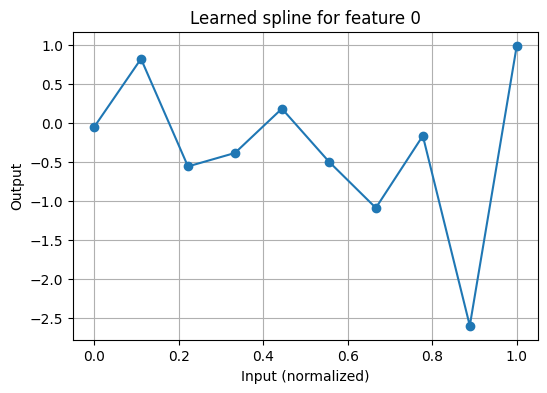

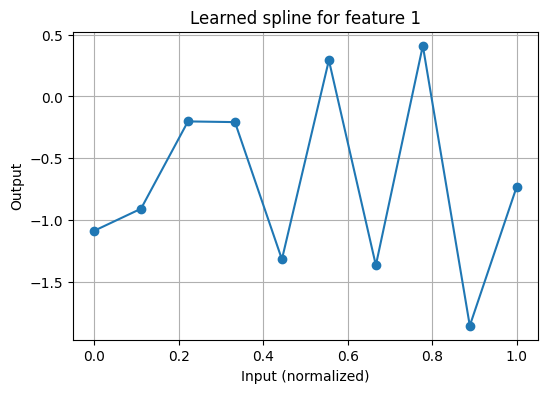

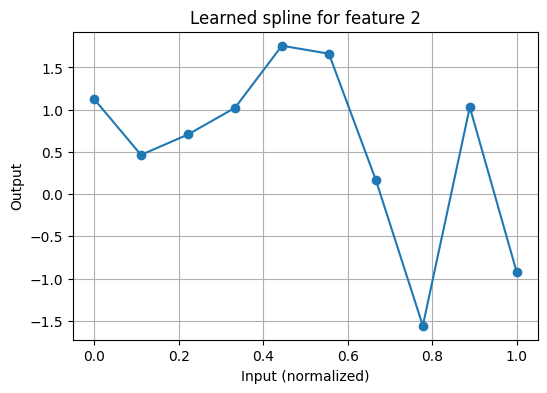

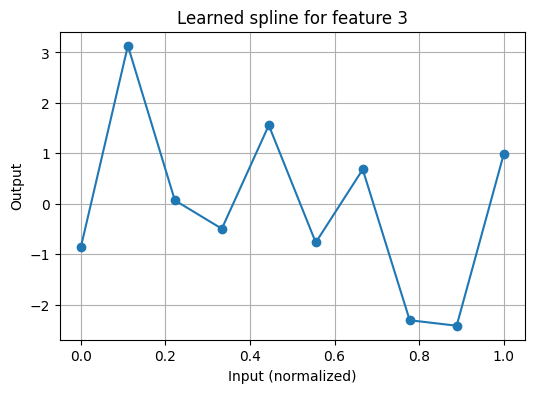

In [35]:
model.psi.visualize(feature_idx=0)
model.psi.visualize(feature_idx=1)
model.phi.visualize(feature_idx=2)
model.phi.visualize(feature_idx=3)

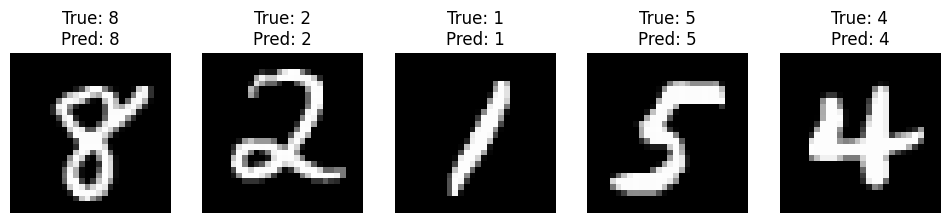

In [39]:
num_examples = 5
indices = np.random.choice(len(X_test_torch), num_examples, replace=False)

model.eval()
with torch.no_grad():
    outputs = model(X_test_torch)
    preds = torch.argmax(outputs, dim=1)

plt.figure(figsize=(12, 4))
for i, idx in enumerate(indices):
    img = X_test[idx].reshape(28, 28)  # numpy массив
    true_label = Y_test[idx]
    pred_label = preds[idx].item()

    plt.subplot(1, num_examples, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.show()